In [51]:
import pandas as pd
import numpy as np

data_path = "./dataset/sensor_readings_24.data"

data = pd.read_csv(data_path, delimiter=",", header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.438,0.498,3.625,3.645,5.000,2.918,5.000,2.351,2.332,2.643,...,0.593,0.502,0.493,0.504,0.445,0.431,0.444,0.440,0.429,Slight-Right-Turn
1,0.438,0.498,3.625,3.648,5.000,2.918,5.000,2.637,2.332,2.649,...,0.592,0.502,0.493,0.504,0.449,0.431,0.444,0.443,0.429,Slight-Right-Turn
2,0.438,0.498,3.625,3.629,5.000,2.918,5.000,2.637,2.334,2.643,...,0.593,0.502,0.493,0.504,0.449,0.431,0.444,0.446,0.429,Slight-Right-Turn
3,0.437,0.501,3.625,3.626,5.000,2.918,5.000,2.353,2.334,2.642,...,0.593,0.502,0.493,0.504,0.449,0.431,0.444,0.444,0.429,Slight-Right-Turn
4,0.438,0.498,3.626,3.629,5.000,2.918,5.000,2.640,2.334,2.639,...,0.592,0.502,0.493,0.504,0.449,0.431,0.444,0.441,0.429,Slight-Right-Turn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5451,0.910,5.000,3.997,2.785,2.770,2.572,2.433,1.087,1.772,1.040,...,0.660,0.648,0.657,0.686,5.000,1.045,5.000,5.000,1.562,Move-Forward
5452,0.926,5.000,4.015,2.792,2.777,2.571,1.768,1.071,1.762,1.021,...,0.652,0.640,0.649,1.593,1.616,1.058,5.000,5.000,1.085,Sharp-Right-Turn
5453,0.937,5.000,4.034,2.799,2.784,2.571,1.754,1.053,1.752,1.002,...,0.648,0.633,0.642,0.741,5.000,1.065,5.000,5.000,1.105,Sharp-Right-Turn
5454,0.945,4.052,4.052,2.809,2.791,2.441,1.757,1.034,1.743,0.983,...,0.641,0.626,0.635,0.754,5.000,1.076,5.000,5.000,1.118,Move-Forward


In [52]:
unique, counts = np.unique(data[24], return_counts=True)
print("Número de classes:", len(unique))
print("Classes e respectivas quantidades de amostras:", dict(zip(unique, counts)))
print("Dimensão do vetor de atributos:", len(data.iloc[0,:-1]))

Número de classes: 4
Classes e respectivas quantidades de amostras: {'Move-Forward': 2205, 'Sharp-Right-Turn': 2097, 'Slight-Left-Turn': 328, 'Slight-Right-Turn': 826}
Dimensão do vetor de atributos: 24


In [53]:
# Principal Component Analysis - PCA

# Normalização Z-Score
def z_score_norm(dataset):
    classes = dataset.iloc[:, -1]
    data = dataset.iloc[:, :-1]
    std = np.std(data, axis=0)
    normalized = (data - np.mean(data, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero
    normalized_dataset = pd.concat([normalized, classes], axis=1)
    return normalized_dataset

# Função para definir a matriz de transformação
def pca_train(dataset, tol):
    X = dataset.iloc[:, :-1]
    n = X.shape[0]

    # Matriz de covariância
    Cx = (X.T @ X) / n
    
    eigenvalues, eigenvectors = np.linalg.eig(Cx)
    
    idxs = eigenvalues.argsort()[::-1] # Índices do maior para o menor
    eigenvalues = np.sort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idxs] # Montagem de autovetores

    var = np.cumsum(eigenvalues) / np.sum(eigenvalues) # variancia explicada

    num_components = np.sum(var <= tol) # Num. compon. principais

    Vq = eigenvectors[:, :num_components] # Matriz com q primeiros autovetores

    return Vq, num_components, var

# Função para aplicar a transformação nos dados
def pca_transform(Vq, dataset):
    classes = dataset.iloc[:, -1]
    X = dataset.iloc[:, :-1]
    Z = X @ Vq # Transformação
    pca_dataset = pd.concat([Z, classes], axis=1)
    return pca_dataset

In [54]:
from sklearn.utils import shuffle

pca_tol = 0.95 # Tolerância do PCA na redução de dimensionalidade

n_classes = len(unique)
data = z_score_norm(data) # Normalização z-score
Vq, Nc, VEq = pca_train(data, pca_tol) # Treinamento do PCA
data = pca_transform(Vq, data)

P_train = 80 # Porcentagem de treino
Nr = 100 # Rodadas de treino/teste

N, p = data.shape
N_train = round(P_train * N / 100)
N_test = N - N_train

print("APLICAÇÃO DO PCA\n")
print("Número de componentes principais para uma tolerância de {0}: {1}".format(pca_tol, Nc))

APLICAÇÃO DO PCA

Número de componentes principais para uma tolerância de 0.95: 20


Variâncias explicadas acumulativas: [0.19266082 0.33479323 0.4111027  0.47773981 0.53269392 0.58129081
 0.62646285 0.66775039 0.69987628 0.72974827 0.75645419 0.7821801
 0.80701362 0.82940599 0.85112006 0.87132174 0.89031993 0.90885485
 0.92703997 0.94380546 0.95950114 0.97409745 0.98790166 1.        ]


Text(0, 0.5, 'Variancia Explicada')

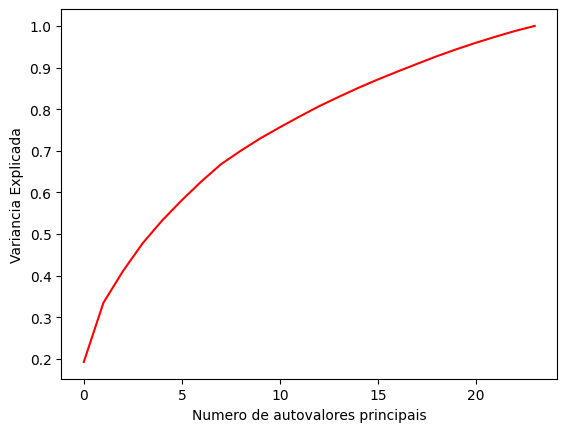

In [55]:
import matplotlib.pyplot as plt

print("Variâncias explicadas acumulativas:", VEq)

plt.plot(VEq, color='red')
plt.xlabel('Numero de autovalores principais')
plt.ylabel('Variancia Explicada')

In [56]:
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,24
0,1.266978,-1.648051,1.633273,-0.443967,0.561083,-0.513475,1.061423,0.903621,0.614134,0.362233,...,-0.255740,-0.645205,0.208042,0.594056,-0.318142,0.514221,-0.391120,0.036623,0.885392,Slight-Right-Turn
1,1.337484,-1.678948,1.550828,-0.437476,0.581067,-0.445085,1.033373,0.877486,0.546160,0.364402,...,-0.224890,-0.644813,0.198306,0.653525,-0.276279,0.503079,-0.356777,0.126933,0.942941,Slight-Right-Turn
2,1.337367,-1.674307,1.547412,-0.439664,0.580386,-0.441403,1.034797,0.877008,0.550407,0.363630,...,-0.226880,-0.647064,0.199935,0.649447,-0.272946,0.503529,-0.354906,0.129842,0.937155,Slight-Right-Turn
3,1.272874,-1.642316,1.624741,-0.436936,0.558105,-0.511683,1.056257,0.906121,0.615960,0.365396,...,-0.261155,-0.649173,0.212960,0.587335,-0.317603,0.508482,-0.380695,0.036540,0.874971,Slight-Right-Turn
4,1.338217,-1.674535,1.548522,-0.441207,0.580582,-0.440384,1.034548,0.878037,0.550746,0.363385,...,-0.225195,-0.646773,0.198848,0.649625,-0.273889,0.502532,-0.354225,0.129422,0.937743,Slight-Right-Turn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5451,-3.501270,-0.370260,0.109899,-1.857663,-1.827899,-1.880045,-0.311483,-0.439691,-1.214482,0.704433,...,-2.678831,-0.902029,-1.026095,-0.051520,1.623217,-0.467513,1.093436,0.103346,-0.891710,Move-Forward
5452,-3.375838,-1.140497,0.296929,-0.517654,-1.275635,-0.767750,-0.450482,0.577442,0.180929,1.085678,...,-0.640362,-0.805367,-0.028019,-0.917670,2.417327,0.288839,0.459625,0.136100,-0.503316,Sharp-Right-Turn
5453,-3.836610,-0.950176,-0.008566,-1.277844,-1.866584,-1.388888,-0.337514,0.933558,-1.530440,0.238747,...,-1.783020,-1.739589,-0.787529,-0.893353,1.999658,-0.108680,0.655665,0.299517,-0.738686,Sharp-Right-Turn
5454,-3.581860,-0.236820,0.093377,-1.736706,-1.842151,-2.231526,0.042098,-0.024801,-1.061608,0.821580,...,-2.608715,-0.769723,-1.068543,0.080482,1.584913,-0.337630,0.870515,0.548326,-0.831438,Move-Forward


In [57]:
# Classificador Quadrático
tx_correct = np.zeros(Nr) # Taxas de acerto de cada rodada
tx_correct_k = {k: [] for k in unique} # Taxas de acerto de cada rodada por classe

for r in range(Nr):
    data = shuffle(data)  # Embaralhando os dados

    # Separando treino e teste
    ds_train = data.iloc[:N_train, :] # Dataset de treino
    ds_test = data.iloc[N_train:, :] # Dataset de teste

    # Particionando os subsets de cada classe
    ds_k_values, mean_k, cx_k, cx_k_inv = {}, {}, {}, {}
    for idx,k in enumerate(unique):
        ds_k = ds_train.loc[ds_train[24] == k] # Amostras da k-ésima classe
        
        ds_k_values[idx] = np.asarray(ds_k.iloc[:,:-1]) # Removendo a coluna de rótulos
        mean_k[idx] = np.mean(ds_k_values[idx], axis=0).reshape(-1, 1)  # Centróide da k-ésima classe
        cx_k[idx] = np.cov(ds_k_values[idx], rowvar=False)  # Matriz de covariância da k-ésima classe
        cx_k_inv[idx] = np.linalg.inv(cx_k[idx])  # Inversa da matriz de covariância da k-ésima classe

    # Etapa de teste
    correct_predictions = 0 # Predições corretas
    n_test_k = {k: 0 for k in unique} # Amostras de teste por classe
    correct_predictions_k = {k: 0 for k in unique} # Predições corretas por classe
    
    for i in range(N_test):
        i_ds_test = np.asarray(ds_test.iloc[i, :-1]).reshape(-1, 1)  # I-ésima amostra de teste
        i_ds_test_class = ds_test.iloc[i, -1]  # Classe da amostra
        
        n_test_k[i_ds_test_class] += 1

        dist = np.zeros(n_classes)
        for idx,k in enumerate(unique):
            v = (i_ds_test - mean_k[idx])
            dist[idx] = v.T @ cx_k_inv[idx] @ v  # Distância de mahalanobis para a k-ésima classe

        pred_class_idx = np.argmin(dist)  # Índice da classe de menor distância
        pred_class = unique[pred_class_idx] # Classe de menor distância

        if pred_class == i_ds_test_class:
            correct_predictions += 1
            correct_predictions_k[i_ds_test_class] += 1

    tx_correct[r] = 100 * correct_predictions / N_test  # Taxa de acerto na R-ésima rodada
    for k in unique:
        tx_correct_k_aux = 100 *  correct_predictions_k[k] / n_test_k[k]
        tx_correct_k[k].append(tx_correct_k_aux)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_7012\2438705714.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist[idx] = v.T @ cx_k_inv[idx] @ v  # Distância de mahalanobis para a k-ésima classe


In [58]:
print("CLASSIFICADOR QUADRÁTICO\n")
print('Taxa de acerto global: {0:.3f}±{1:.3f}'.format(np.mean(tx_correct), np.std(tx_correct)))
print("Taxa de acerto para cada classe:")
for k, stats in tx_correct_k.items():
    print("\tClasse {0}: {1:.3f}±{2:.3f}".format(k, np.mean(stats), np.std(stats)))

CLASSIFICADOR QUADRÁTICO

Taxa de acerto global: 69.557±1.308
Taxa de acerto para cada classe:
	Classe Move-Forward: 67.022±2.248
	Classe Sharp-Right-Turn: 85.771±1.875
	Classe Slight-Left-Turn: 65.708±5.844
	Classe Slight-Right-Turn: 36.412±4.450


In [59]:
# Classificador Quadrático - Variante 2
tx_correct = np.zeros(Nr) # Taxas de acerto de cada rodada
tx_correct_k = {k: [] for k in unique} # Taxas de acerto de cada rodada por classe

for r in range(Nr):
    data = shuffle(data)  # Embaralhando os dados

    # Separando treino e teste
    ds_train = data.iloc[:N_train, :] # Dataset de treino
    ds_test = data.iloc[N_train:, :] # Dataset de teste

    # Particionando os subsets de cada classe
    cx_pool = np.zeros((p-1, p-1))
    n_k, ds_k_values, mean_k, cx_k = {}, {}, {}, {}
    for idx,k in enumerate(unique):
        ds_k = ds_train.loc[ds_train[24] == k] # Amostras da k-ésima classe
        
        n_k[k] = ds_k.shape[0] # Num de amostras da k-ésima classse
        ds_k_values[idx] = np.asarray(ds_k.iloc[:,:-1]) # Removendo a coluna de rótulos
        mean_k[idx] = np.mean(ds_k_values[idx], axis=0).reshape(-1, 1)  # Centróide da k-ésima classe
        
        cx_k[idx] = (n_k[k] / N_train) * np.cov(ds_k_values[idx], rowvar=False)  # Matriz de covariância da k-ésima classe
        cx_pool += cx_k[idx] # Matriz de covariância agregada

    cx_pool_inv = np.linalg.pinv(cx_pool)  # Inversa da matriz de covariância agregada

    # Etapa de teste
    correct_predictions = 0 # Predições corretas
    n_test_k = {k: 0 for k in unique} # Amostras de teste por classe
    correct_predictions_k = {k: 0 for k in unique} # Predições corretas por classe
    
    for i in range(N_test):
        i_ds_test = np.asarray(ds_test.iloc[i, :-1]).reshape(-1, 1)  # I-ésima amostra de teste
        i_ds_test_class = ds_test.iloc[i, -1]  # Classe da amostra
        
        n_test_k[i_ds_test_class] += 1

        dist = np.zeros(n_classes)
        for idx,k in enumerate(unique):
            v = (i_ds_test - mean_k[idx])
            dist[idx] = v.T @ cx_k_inv[idx] @ v  # Distância de mahalanobis para a k-ésima classe

        pred_class_idx = np.argmin(dist)  # Índice da classe de menor distância
        pred_class = unique[pred_class_idx] # Classe de menor distância

        if pred_class == i_ds_test_class:
            correct_predictions += 1
            correct_predictions_k[i_ds_test_class] += 1

    tx_correct[r] = 100 * correct_predictions / N_test  # Taxa de acerto na R-ésima rodada
    for k in unique:
        tx_correct_k_aux = 100 *  correct_predictions_k[k] / n_test_k[k]
        tx_correct_k[k].append(tx_correct_k_aux)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_7012\1139017623.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist[idx] = v.T @ cx_k_inv[idx] @ v  # Distância de mahalanobis para a k-ésima classe


In [60]:
print("CLASSIFICADOR QUADRÁTICO - VARIANTE 2\n")
print('Taxa de acerto global: {0:.3f}±{1:.3f}'.format(np.mean(tx_correct), np.std(tx_correct)))
print("Taxa de acerto para cada classe:")
for k, stats in tx_correct_k.items():
    print("\tClasse {0}: {1:.3f}±{2:.3f}".format(k, np.mean(stats), np.std(stats)))

CLASSIFICADOR QUADRÁTICO - VARIANTE 2

Taxa de acerto global: 70.483±1.353
Taxa de acerto para cada classe:
	Classe Move-Forward: 66.461±1.958
	Classe Sharp-Right-Turn: 87.137±1.693
	Classe Slight-Left-Turn: 69.254±4.526
	Classe Slight-Right-Turn: 39.653±3.742


In [61]:
# Classificador Quadrático - Variante 4
tx_correct = np.zeros(Nr) # Taxas de acerto de cada rodada
tx_correct_k = {k: [] for k in unique} # Taxas de acerto de cada rodada por classe

for r in range(Nr):
    data = shuffle(data)  # Embaralhando os dados

    # Separando treino e teste
    ds_train = data.iloc[:N_train, :] # Dataset de treino
    ds_test = data.iloc[N_train:, :] # Dataset de teste

    # Particionando os subsets de cada classe
    ds_k_values, mean_k, var_k, cx_k, cx_k_inv = {}, {}, {}, {}, {}
    for idx,k in enumerate(unique):
        ds_k = ds_train.loc[ds_train[24] == k] # Amostras da k-ésima classe
        
        ds_k_values[idx] = np.asarray(ds_k.iloc[:,:-1]) # Removendo a coluna de rótulos
        mean_k[idx] = np.mean(ds_k_values[idx], axis=0).reshape(-1, 1)  # Centróide da k-ésima classe
        var_k[k] = 1 / np.var(ds_k_values[idx], axis=0) # Variâncias dos atributos da k-ésima classe
        cx_k_inv[idx] = np.diag(var_k[k])  # Matriz de covariância da k-ésima classe a partir da matriz diagonal das inversa variâncias
        # cx_k_inv[idx] = np.linalg.inv(cx_k[idx])  # Inversa da matriz de covariância da k-ésima classe
        # cx_k_inv[idx] = np.divide(1, cx_k[idx])  # Inversa da matriz de covariância da k-ésima classe

    # Etapa de teste
    correct_predictions = 0 # Predições corretas
    n_test_k = {k: 0 for k in unique} # Amostras de teste por classe
    correct_predictions_k = {k: 0 for k in unique} # Predições corretas por classe
    
    for i in range(N_test):
        i_ds_test = np.asarray(ds_test.iloc[i, :-1]).reshape(-1, 1)  # I-ésima amostra de teste
        i_ds_test_class = ds_test.iloc[i, -1]  # Classe da amostra
        
        n_test_k[i_ds_test_class] += 1

        dist = np.zeros(n_classes)
        for idx,k in enumerate(unique):
            v = (i_ds_test - mean_k[idx])
            dist[idx] = v.T @ cx_k_inv[idx] @ v  # Distância de mahalanobis para a k-ésima classe

        pred_class_idx = np.argmin(dist)  # Índice da classe de menor distância
        pred_class = unique[pred_class_idx] # Classe de menor distância

        if pred_class == i_ds_test_class:
            correct_predictions += 1
            correct_predictions_k[i_ds_test_class] += 1

    tx_correct[r] = 100 * correct_predictions / N_test  # Taxa de acerto na R-ésima rodada
    for k in unique:
        tx_correct_k_aux = 100 *  correct_predictions_k[k] / n_test_k[k]
        tx_correct_k[k].append(tx_correct_k_aux)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_7012\2133649351.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist[idx] = v.T @ cx_k_inv[idx] @ v  # Distância de mahalanobis para a k-ésima classe


In [62]:
print("CLASSIFICADOR QUADRÁTICO - VARIANTE 4\n")
print('Taxa de acerto global: {0:.3f}±{1:.3f}'.format(np.mean(tx_correct), np.std(tx_correct)))
print("Taxa de acerto para cada classe:")
for k, stats in tx_correct_k.items():
    print("\tClasse {0}: {1:.3f}±{2:.3f}".format(k, np.mean(stats), np.std(stats)))

CLASSIFICADOR QUADRÁTICO - VARIANTE 4

Taxa de acerto global: 60.738±1.293
Taxa de acerto para cada classe:
	Classe Move-Forward: 42.439±2.041
	Classe Sharp-Right-Turn: 96.528±1.072
	Classe Slight-Left-Turn: 55.533±6.616
	Classe Slight-Right-Turn: 21.397±3.018


In [63]:
# Classificador Linear de Mínimos Quadrados

# Colocar y em formato de vetor (one hot)
def one_hot_convert(vec):
    matrix = []
    for k in vec:
        m = np.zeros((4, 1))
        idx = unique.tolist().index(k)
        m[idx] = 1
        matrix.append(m)
    return np.array(matrix)
    
tx_correct = np.zeros(Nr) # Taxas de acerto de cada rodada
tx_correct_k = {k: [] for k in unique} # Taxas de acerto de cada rodada por classe

for r in range(Nr):
    data = shuffle(data)  # Embaralhando os dados

    # Separando treino e teste
    ds_train = data.iloc[:N_train, :] # Dataset de treino
    ds_test = data.iloc[N_train:, :] # Dataset de teste

    X_train = np.asarray(ds_train.iloc[:,:-1]) # Matriz de dados
    y_train = one_hot_convert(np.asarray(ds_train.iloc[:,-1])).reshape(ds_train.shape[0], -1) # Matriz de classes (formato one-hot)

    W = np.linalg.pinv(X_train) @ y_train # Matriz de pesos

    # Etapa de teste
    correct_predictions = 0 # Predições corretas
    n_test_k = {k: 0 for k in unique} # Amostras de teste por classe
    correct_predictions_k = {k: 0 for k in unique} # Predições corretas por classe
    
    for i in range(N_test):
        X_test = np.asarray(ds_test.iloc[i, :-1]).reshape(-1, 1)  # I-ésima amostra de teste
        i_ds_test_class = ds_test.iloc[i, -1]  # Classe da amostra
        y_test = unique.tolist().index(i_ds_test_class)  # Índice da classe da amostra
        
        n_test_k[i_ds_test_class] += 1

        y_pred = X_test.T @ W # Cálculo da predição

        pred_class = np.argmax(y_pred, axis=1)[0]  # Classe predita em forma

        if pred_class == y_test:
            correct_predictions += 1
            correct_predictions_k[i_ds_test_class] += 1

    tx_correct[r] = 100 * correct_predictions / N_test  # Taxa de acerto na R-ésima rodada
    for k in unique:
        tx_correct_k_aux = 100 *  correct_predictions_k[k] / n_test_k[k]
        tx_correct_k[k].append(tx_correct_k_aux)

In [64]:
print("CLASSIFICADOR LINEAR DE MÍNIMOS QUADRADOS\n")
print('Taxa de acerto global: {0:.3f}±{1:.3f}'.format(np.mean(tx_correct), np.std(tx_correct)))
print("Taxa de acerto para cada classe:")
for k, stats in tx_correct_k.items():
    print("\tClasse {0}: {1:.3f}±{2:.3f}".format(k, np.mean(stats), np.std(stats)))

CLASSIFICADOR LINEAR DE MÍNIMOS QUADRADOS

Taxa de acerto global: 63.810±1.345
Taxa de acerto para cada classe:
	Classe Move-Forward: 57.981±2.057
	Classe Sharp-Right-Turn: 73.461±1.939
	Classe Slight-Left-Turn: 76.946±4.511
	Classe Slight-Right-Turn: 49.894±3.379
